# Predict the customer churn with neural networks
I ran this notebook in Google colab. The first cell is necessary to mount you colab into your google drive, where you can store and access the data files.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!ls  "/content/drive/MyDrive/Colab_notebooks"

## Imports
Import keras tuner, to tune neural networks like scikit-learn algorithms ([Link](https://keras.io/keras_tuner/)). We'll see how well it works...

In [3]:
!pip install keras-tuner

     |████████████████████████████████| 97 kB 3.2 MB/s 


In [ ]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

from keras_tuner.tuners import RandomSearch

import tensorflow as tf
from tensorflow import keras

import pickle

print("Here is Tensorflow", tf.__version__)


## Load Data

In [ ]:

DEFAULT_DATA_PATH = "/content/drive/MyDrive/Colab_notebooks/"

pickle_in = open(DEFAULT_DATA_PATH + "data/X_train.p", "rb")
X_train = pd.DataFrame(pickle.load(pickle_in))
pickle_in.close()

pickle_in = open(DEFAULT_DATA_PATH + "data/y_train.p", "rb")
y_train = pd.DataFrame(pickle.load(pickle_in))
pickle_in.close()

pickle_in = open(DEFAULT_DATA_PATH + "data/X_test.p", "rb")
X_test = pd.DataFrame(pickle.load(pickle_in))
pickle_in.close()

pickle_in = open(DEFAULT_DATA_PATH + "data/y_test.p", "rb")
y_test = pd.DataFrame(pickle.load(pickle_in))
pickle_in.close()

print("data loaded")

In [ ]:
## create validation set
# kernel failed by execution
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,test_size=0.2,random_state=123)


# Building the model

In [8]:
# Input Layer: 20 neurons
# hidden Layers: 1 to 5 
# Outplut Layer: 1 Neuron
# Output Activation function: logistic
# Loss function cross entropy

In [9]:
model = keras.Sequential()
model.add(keras.layers.Flatten(input_shape=[1, 20]))
model.add(keras.layers.Dense(13, activation="relu"))
model.add(keras.layers.Dense(7, activation="relu"))
model.add(keras.layers.Dense(1, activation="sigmoid"))

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 20)                0         
_________________________________________________________________
dense (Dense)                (None, 13)                273       
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 98        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 8         
Total params: 379
Trainable params: 379
Non-trainable params: 0
_________________________________________________________________


In [11]:
# compiling
adam_opt = keras.optimizers.Adam(lr = .01)

model.compile(loss="binary_crossentropy",
    optimizer=adam_opt, 
    metrics=["accuracy"])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [12]:
# establish call backs
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, 
                                                  restore_best_weights=True)
checkpoint_cb = keras.callbacks.ModelCheckpoint("churn_model.h5", 
                                                save_best_only=True)

# train first model

training_history = model.fit(X_train, y_train, epochs=100, 
                             validation_data=(X_val, y_val), 
                             callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
233/233 [==============================] - 4s 5ms/step - loss: 0.5100 - accuracy: 0.7463 - val_loss: 0.4554 - val_accuracy: 0.7826
Epoch 2/100
233/233 [==============================] - 1s 4ms/step - loss: 0.4765 - accuracy: 0.7597 - val_loss: 0.4602 - val_accuracy: 0.7783
Epoch 3/100
233/233 [==============================] - 1s 4ms/step - loss: 0.4721 - accuracy: 0.7664 - val_loss: 0.4365 - val_accuracy: 0.7955
Epoch 4/100
233/233 [==============================] - 1s 4ms/step - loss: 0.4623 - accuracy: 0.7667 - val_loss: 0.4432 - val_accuracy: 0.7896
Epoch 5/100
233/233 [==============================] - 1s 4ms/step - loss: 0.4597 - accuracy: 0.7766 - val_loss: 0.4338 - val_accuracy: 0.7923
Epoch 6/100
233/233 [==============================] - 1s 4ms/step - loss: 0.4552 - accuracy: 0.7791 - val_loss: 0.4422 - val_accuracy: 0.7874
Epoch 7/100
233/233 [==============================] - 1s 4ms/step - loss: 0.4537 - accuracy: 0.7804 - val_loss: 0.4495 - val_accuracy: 0.7858

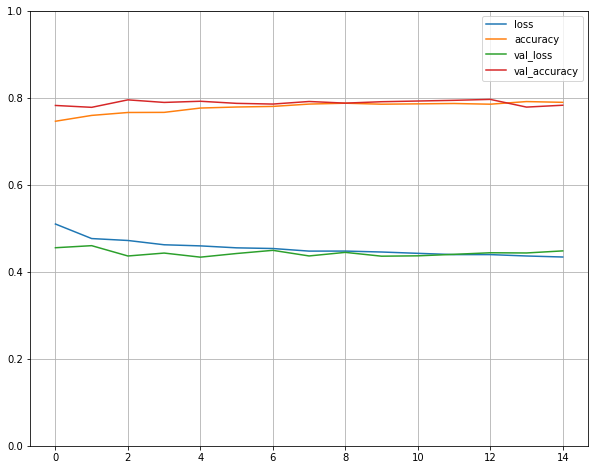

In [13]:
pd.DataFrame(training_history.history).plot(figsize = (10, 8))
plt.grid()
plt.ylim(0,1)
plt.show()

## Hyperparameter tuning

In [14]:
def build_model(hp):
  model_tuned = keras.models.Sequential()
  model_tuned.add(keras.layers.Flatten(input_shape=[20]))
  for layer in range(hp.Int('h_layers',
                            min_value=1,
                            max_value=5,
                            step=1)):
    model_tuned.add(keras.layers.Dense(hp.Int('neurons',
                                              min_value=3,
                                              max_value=18,
                                              step=3), 
                                       activation="relu"))
  model_tuned.add(keras.layers.Dense(1, activation="sigmoid"))

  opt = keras.optimizers.Adam(lr = hp.Choice('learning_rate',
                                             [0.1, 0.01, 0.001, 0.0001]))
  model_tuned.compile(loss="binary_crossentropy", optimizer=opt)
  return model_tuned

In [15]:
# wrap the keras model, so we can tune it like a scikit model

# keras_clas = keras.wrappers.scikit_learn.KerasClassifier(build_model)

tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=5,
    executions_per_trial=2,
    directory=DEFAULT_DATA_PATH + 'models',
    project_name='telco_model')

INFO:tensorflow:Reloading Oracle from existing project /content/drive/MyDrive/Colab_notebooks/models/telco_model/oracle.json
INFO:tensorflow:Reloading Tuner from /content/drive/MyDrive/Colab_notebooks/models/telco_model/tuner0.json


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [16]:
# print(tuner.search_space_summary())

tuner.search(x=X_train, y=y_train, epochs=20, validation_data = (X_val, y_val))
print(tuner.results_summary())

INFO:tensorflow:Oracle triggered exit
Results summary
Results in /content/drive/MyDrive/Colab_notebooks/models/telco_model
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
h_layers: 2
neurons: 9
learning_rate: 0.01
Score: 0.43087054044008255
Trial summary
Hyperparameters:
h_layers: 3
neurons: 6
learning_rate: 0.01
Score: 0.43252476304769516
Trial summary
Hyperparameters:
h_layers: 2
neurons: 9
learning_rate: 0.0001
Score: 0.47699520736932755
Trial summary
Hyperparameters:
h_layers: 4
neurons: 6
learning_rate: 0.0001
Score: 0.5017941072583199
Trial summary
Hyperparameters:
h_layers: 4
neurons: 3
learning_rate: 0.01
Score: 0.5057656839489937
None


**Final thoughts:**  
As we can see, this hyperparameter tuning is not close to the manually selected params at all. That seems logical to me because in the tuning model, each hidden layer must have the same number of neurons, which leads to a very unorganical network.